### Logistic Regression implementation

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

class OurLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            #print(gradient.shape, self.w.shape, z.shape,h.shape)
            #gradient = (h - y) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def accurancy(self, y_pred,y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return roc_auc
    
    def plot_roc(self, y_pred, y_test):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        # graficar la curva ROC
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de falsos positivos')
        plt.ylabel('Tasa de verdaderos positivos')
        plt.title('Curva ROC para un modelo de regresión logística')
        plt.legend(loc="lower right")
        plt.show()


### Red Wine Dataset

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# read the data set
df_wine = pd.read_csv('datasets/winequality-red.csv')

"""
Data preprocessing - outlier treatment
eliminating items from outside from of the 
1.5 * Inter Quartile Range (0.125% to 0.875% of the data)
"""
l_limit_perc = 0.01
h_limit_perc = 0.99

# fixed acidity
low_limit = df_wine['fixed acidity'].quantile(l_limit_perc)
high_limit = df_wine['fixed acidity'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['fixed acidity'] >= low_limit) & (df_wine['fixed acidity'] <= high_limit)]

# volatile acidity
low_limit = df_wine['volatile acidity'].quantile(l_limit_perc)
high_limit = df_wine['volatile acidity'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['volatile acidity'] >= low_limit) & (df_wine['volatile acidity'] <= high_limit)]

# citric acid
low_limit = df_wine['citric acid'].quantile(l_limit_perc)
high_limit = df_wine['citric acid'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['citric acid'] >= low_limit) & (df_wine['citric acid'] <= high_limit)]

# residual sugar
low_limit = df_wine['residual sugar'].quantile(l_limit_perc)
high_limit = df_wine['residual sugar'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['residual sugar'] >= low_limit) & (df_wine['residual sugar'] <= high_limit)]

# chlorides
low_limit = df_wine['chlorides'].quantile(l_limit_perc)
high_limit = df_wine['chlorides'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['chlorides'] >= low_limit) & (df_wine['chlorides'] <= high_limit)]

# free sulfur dioxide
low_limit = df_wine['free sulfur dioxide'].quantile(l_limit_perc)
high_limit = df_wine['free sulfur dioxide'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['free sulfur dioxide'] >= low_limit) & (df_wine['free sulfur dioxide'] <= high_limit)]

# total sulfur dioxide
low_limit = df_wine['total sulfur dioxide'].quantile(l_limit_perc)
high_limit = df_wine['total sulfur dioxide'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['total sulfur dioxide'] >= low_limit) & (df_wine['total sulfur dioxide'] <= high_limit)]

# density
low_limit = df_wine['density'].quantile(l_limit_perc)
high_limit = df_wine['density'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['density'] >= low_limit) & (df_wine['density'] <= high_limit)]

# pH
low_limit = df_wine['pH'].quantile(l_limit_perc)
high_limit = df_wine['pH'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['pH'] >= low_limit) & (df_wine['pH'] <= high_limit)]

# sulphates
low_limit = df_wine['sulphates'].quantile(l_limit_perc)
high_limit = df_wine['sulphates'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['sulphates'] >= low_limit) & (df_wine['sulphates'] <= high_limit)]

# alcohol
low_limit = df_wine['alcohol'].quantile(l_limit_perc)
high_limit = df_wine['alcohol'].quantile(h_limit_perc)
df_wine = df_wine.loc[(df_wine['alcohol'] >= low_limit) & (df_wine['alcohol'] <= high_limit)]

# Feature engineering 
df_wine['alcohol'] = (df_wine['alcohol']-df_wine['alcohol'].mean())/df_wine['alcohol'].std()
df_wine['chlorides'] = (df_wine['chlorides']-df_wine['chlorides'].mean())/df_wine['chlorides'].std()
df_wine['citric acid'] = (df_wine['citric acid']-df_wine['citric acid'].mean())/df_wine['citric acid'].std()
df_wine['density'] = (df_wine['density']-df_wine['density'].mean())/df_wine['density'].std()
df_wine['fixed acidity'] = (df_wine['fixed acidity']-df_wine['fixed acidity'].mean())/df_wine['fixed acidity'].std()
df_wine['free sulfur dioxide'] = (df_wine['free sulfur dioxide']-df_wine['free sulfur dioxide'].mean())/df_wine['free sulfur dioxide'].std()
df_wine['pH'] = (df_wine['pH']-df_wine['pH'].mean())/df_wine['pH'].std()
df_wine['residual sugar'] = (df_wine['residual sugar']-df_wine['residual sugar'].mean())/df_wine['residual sugar'].std()
df_wine['sulphates'] = (df_wine['sulphates']-df_wine['sulphates'].mean())/df_wine['sulphates'].std()
df_wine['total sulfur dioxide'] = (df_wine['total sulfur dioxide']-df_wine['total sulfur dioxide'].mean())/df_wine['total sulfur dioxide'].std()
df_wine['volatile acidity'] = (df_wine['volatile acidity']-df_wine['volatile acidity'].mean())/df_wine['volatile acidity'].std()

# change the value of the output to only two values
# 0 -> bad wine, wines with 3, 4 and 5 in quality
# 1 -> good wine, wines with 6, 7 and 8 in queality
df_wine.loc[df_wine['quality'] <= 5, 'quality'] = 0
df_wine.loc[df_wine['quality'] > 5, 'quality'] = 1

# Define the training and test set

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
X0 = df_wine.loc[df_wine['quality'] == 0, features]
Y0 = df_wine.loc[df_wine['quality'] == 0, 'quality']

X1 = df_wine.loc[df_wine['quality'] == 1, features]
Y1 = df_wine.loc[df_wine['quality'] == 1, 'quality']

test_percentage = 0.2

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=test_percentage, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=test_percentage, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
X_test = pd.concat([X0_test, X1_test], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)
y_test = pd.concat([y0_test, y1_test], axis= 0)

### Train model and test results

Accuracy:  0.7565543071161048
Precision:  0.7794117647058824
Recall:  0.75177304964539
AUC:  0.756838905775076


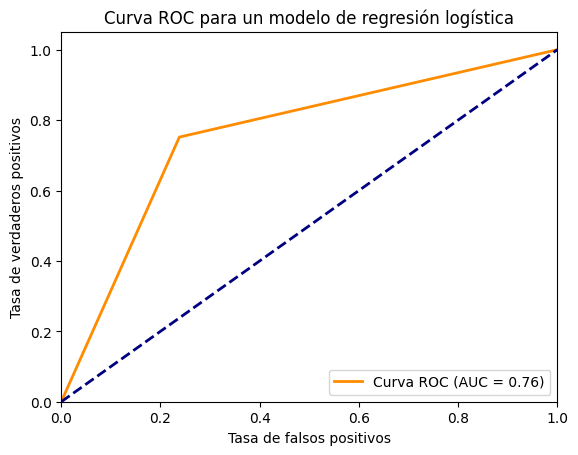

In [33]:
model = OurLogisticRegression(lr=0.03, num_iter=100)

# fit the model to the training data
model.fit(X_train, y_train)

# predict probabilities for test set
probs = model.predict_prob(X_test)

# predict classes for test set
y_pred = model.predict(X_test, 0.5)

print("Accuracy: ", model.accurancy(y_pred, y_test))
print("Precision: ", model.precision(y_pred, y_test))
print("Recall: ", model.recall(y_pred, y_test))
print("AUC: ", model.auc(y_pred, y_test))
model.plot_roc(y_pred, y_test)
